<a href="https://colab.research.google.com/github/CarolinaRamalhoGit/MVP_Qualidade_de_software_Seguranca_e_Sistemas_inteligentes/blob/main/MVP_CGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo de _Machine Learning_ para a Predição de Câncer de Mama**


#1. Introdução

Este notebook é parte do MVP - _Minimum Viable Product_ - da _Sprint_ **Qualidade de Software, Segurança e Sistemas Inteligentes**. do Curso de Engenharia de Software da PUC-Rio.

O presente _notebook_ contém o Modelo de _Machine Learning_ treinado para a classificação e predição de tipos de tumores mamários (benignos ou malignos), utilizando como base o _dataset Diagnostic Wisconsin Breast Cancer_ disponível no [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

Este _dataset_ foi criado a partir de imagens de biópsias de tumores de mama, coletadas e analisadas pela Universidade de Wisconsin. De acordo com o [artigo original](https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf?sequence=1), foram utilizadas técnicas de processamento de imagem, que permitiram extrair 10 características que descrevem propriedades de cada núcleo de um conjunto das células do tumor de 569 indivíduos, como tamanho, forma, textura, dentre outros. Para cada um desses conjuntos foram calculados a média, o desvio-padrão e o "pior" (ou maior) valor, resultando, assim, em 30 características para cada indivíduo, além da característica-alvo: a benignidade ou malignidade do tumor.

Este _notebook_ está dividido nos seguintes tópicos:

1. Introdução
2. Configuração do ambiente
3. Importação e análise dos dados
4. Pré-processamento
5. Modelagem
6. Exportação do modelo
7. Simulação com dados não vistos
8. Conclusão



#2. Configuração do ambiente

In [39]:
# Configurações e importações necessárias

# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários:
#
# Biblioteca do repositório UCI Machine Learning Repository
%pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt1
import matplotlib.pylab as plt2
import matplotlib.colors as colors
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from pickle import dump
from pickle import load

from google.colab import files

#3. Importação e análise dos dados

##3.1. Importação

Conforme apresentado na Introdução, este dataset contém informações sobre imagens de biópsias de tumores de mama. Foram coletadas informações de 10 características que descrevem as propriedades de cada núcleo de um conjunto das células do tumor:

1. Raio (Radius): Média das distâncias do centro para os pontos no perímetro da célula. Caracteriza o tamanho médio das células.
2. Textura (Texture): Desvio padrão dos valores de intensidade de cinza dentro da célula, refletindo a variação na aparência da superfície celular.
3. Perímetro (Perimeter): Medida da circunferência da célula, obtida pelo contorno da célula.
4. Área (Area): Mede o tamanho da célula em termos de espaço ocupado.
5. Suavidade (Smoothness): Variação local nos comprimentos dos raios, indicando quão suaves são as bordas das células.
6. Compacidade (Compactness): Mede a compacidade da célula, indicando quão densa ou compacta a célula é.
7. Concavidade (Concavity): Extensão das concavidades nas bordas da célula, ou seja, quanto as bordas da célula são côncavas.
8. Pontos Côncavos (Concave Points): Número de pontos côncavos específicos na borda da célula, representando pequenas indentações.
9. Simetria (Symmetry): Mede quão simétrica é a célula.
10. Dimensão Fractal (Fractal Dimension): Mede a complexidade das bordas da célula, calculando "rugosidade" ou "irregularidade" nas bordas.

O dataset possui 30 colunas de característcas (_features_), que são divididas em três grupos de 10 características:

- As 10 primeiras colunas correspondem às médias de cada uma das características descritas (raio, textura, perímetro, etc.) para as células analisadas. Seus nomes no dataset são "radius1", "texture1", "perimeter1" etc.
- As próximas 10 colunas representam os desvios-padrão dessas mesmas características, que indicam a variabilidade de cada medida dentro da amostra. Seus nomes no dataset são "radius2", "texture2", "perimeter2" etc.
- As 10 últimas colunas contêm os piores valores (ou seja, os maiores valores registrados) para cada característica, fornecendo informações sobre as características mais extremas das células. Seus nomes no dataset são "radius3", "texture3", "perimeter3" etc.

Já a característica alvo (_target_), é o Diagnóstico da Malignidade do Tumor, assumindo valores M, para os tumores malignos, e B, para os tumores benignos. Por se tratar de dados categóricos, os mesmos foram transformados em dados númericos, fazendo-se 1, para tumores malignos, e 0, para tumores benignos.

A importação foi feita seguindo a recomendação da página do repositório (UCI Machine Learning Repository), por meio da função <code>fetch_ucirepo()</code>, da biblioteca <code>ucimlrepo</code>.


In [2]:
# fetch dataset
data = fetch_ucirepo(id=17)

features = pd.DataFrame(data.data.features)
target = pd.DataFrame(data.data.targets)

# Converte 'M' e 'B' em 1 e 0, respectivamente
target['Diagnosis'] = target['Diagnosis'].map({'M': 1, 'B': 0})

# Concatena as features e o target em um único DataFrame
numeric_target = target.apply(pd.to_numeric)
dataset = pd.concat([features, numeric_target], axis=1)

# Apresenta as primeiras linhas do dataset concatenado (features e target)
dataset.head(10)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,1
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,1
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,1
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,1
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,1


##3.2. Análise dos dados


Foi realizada uma breve análise exploratória dos dados, na qual pôde-se observar:

- Não há valores ausentes e nem duplicados no conjunto de dados, o que elimina a necessidade de tratamento de dados para estes casos;
- A distribuição das classes é levemente desbalanceada, com 62,7% das amostras sendo benignas e 37,3% malignas. Apesar deste não ser um forte desbalanceamento, este valor indica a necessidade de outras medidas de avaliação do modelo além da acurácia, afim de verificar uma possível tendência do modelo a prever a classe majoritária, o que levaria a falsos negativos.

In [13]:
# Verificação de dados faltantes
missing_data = dataset.isnull().sum()

if missing_data.sum() == 0:
    print("Não existem dados faltantes no dataset.")
else:
    # Exibe uma tabela com as colunas que possuem dados faltantes
    print("Colunas com dados faltantes:")
    print(missing_data[missing_data > 0])

# Verificação de dados duplicados
print(f"Existem {dataset.duplicated().sum()} dados duplicados no dataset.")

# Verificando o balanceamento entre as classes da variável alvo
total_amostras = len(dataset)
contagem_classes = dataset['Diagnosis'].value_counts()
percent_benigno = (contagem_classes[0] / total_amostras) * 100
percent_maligno = (contagem_classes[1] / total_amostras) * 100
print(f"Percentual de tumores benignos: {percent_benigno:.2f}%")
print(f"Percentual de tumores malignos: {percent_maligno:.2f}%")

Não existem dados faltantes no dataset.
Existem 0 dados duplicados no dataset.
Percentual de tumores benignos: 62.74%
Percentual de tumores malignos: 37.26%


- Nas estatísticas descritivas, observa-se que as características variam em escala, sugerindo a necessidade de padronização ou normalização como pré-processamento do conjunto de treino do modelo;

In [14]:
# Estatística descritiva das características da amostra
dataset.describe().applymap(lambda x: f'{x:.2f}')

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
count,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,...,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00
mean,14.13,19.29,91.97,654.89,0.10,0.10,0.09,0.05,0.18,0.06,...,25.68,107.26,880.58,0.13,0.25,0.27,0.11,0.29,0.08,0.37
std,3.52,4.30,24.30,351.91,0.01,0.05,0.08,0.04,0.03,0.01,...,6.15,33.60,569.36,0.02,0.16,0.21,0.07,0.06,0.02,0.48
min,6.98,9.71,43.79,143.50,0.05,0.02,0.00,0.00,0.11,0.05,...,12.02,50.41,185.20,0.07,0.03,0.00,0.00,0.16,0.06,0.00
25%,11.70,16.17,75.17,420.30,0.09,0.06,0.03,0.02,0.16,0.06,...,21.08,84.11,515.30,0.12,0.15,0.11,0.06,0.25,0.07,0.00
50%,13.37,18.84,86.24,551.10,0.10,0.09,0.06,0.03,0.18,0.06,...,25.41,97.66,686.50,0.13,0.21,0.23,0.10,0.28,0.08,0.00
75%,15.78,21.80,104.10,782.70,0.11,0.13,0.13,0.07,0.20,0.07,...,29.72,125.40,1084.00,0.15,0.34,0.38,0.16,0.32,0.09,1.00
max,28.11,39.28,188.50,2501.00,0.16,0.35,0.43,0.20,0.30,0.10,...,49.54,251.20,4254.00,0.22,1.06,1.25,0.29,0.66,0.21,1.00


- Nos histogramas, pode-se observar que a maioria das características apresenta algum grau de assimetria, especialmente nos valores maiores (assimetria positiva). Há também presença de curvas com maior dispersão em torno da média, especialmente no conjunto de características dos piores valores. Estes comportamento podem denotar a presença de outliers, que, no contexto, podem ser justamente o que diferenciam os tumores malignos (a minoria observada) dos benignos.

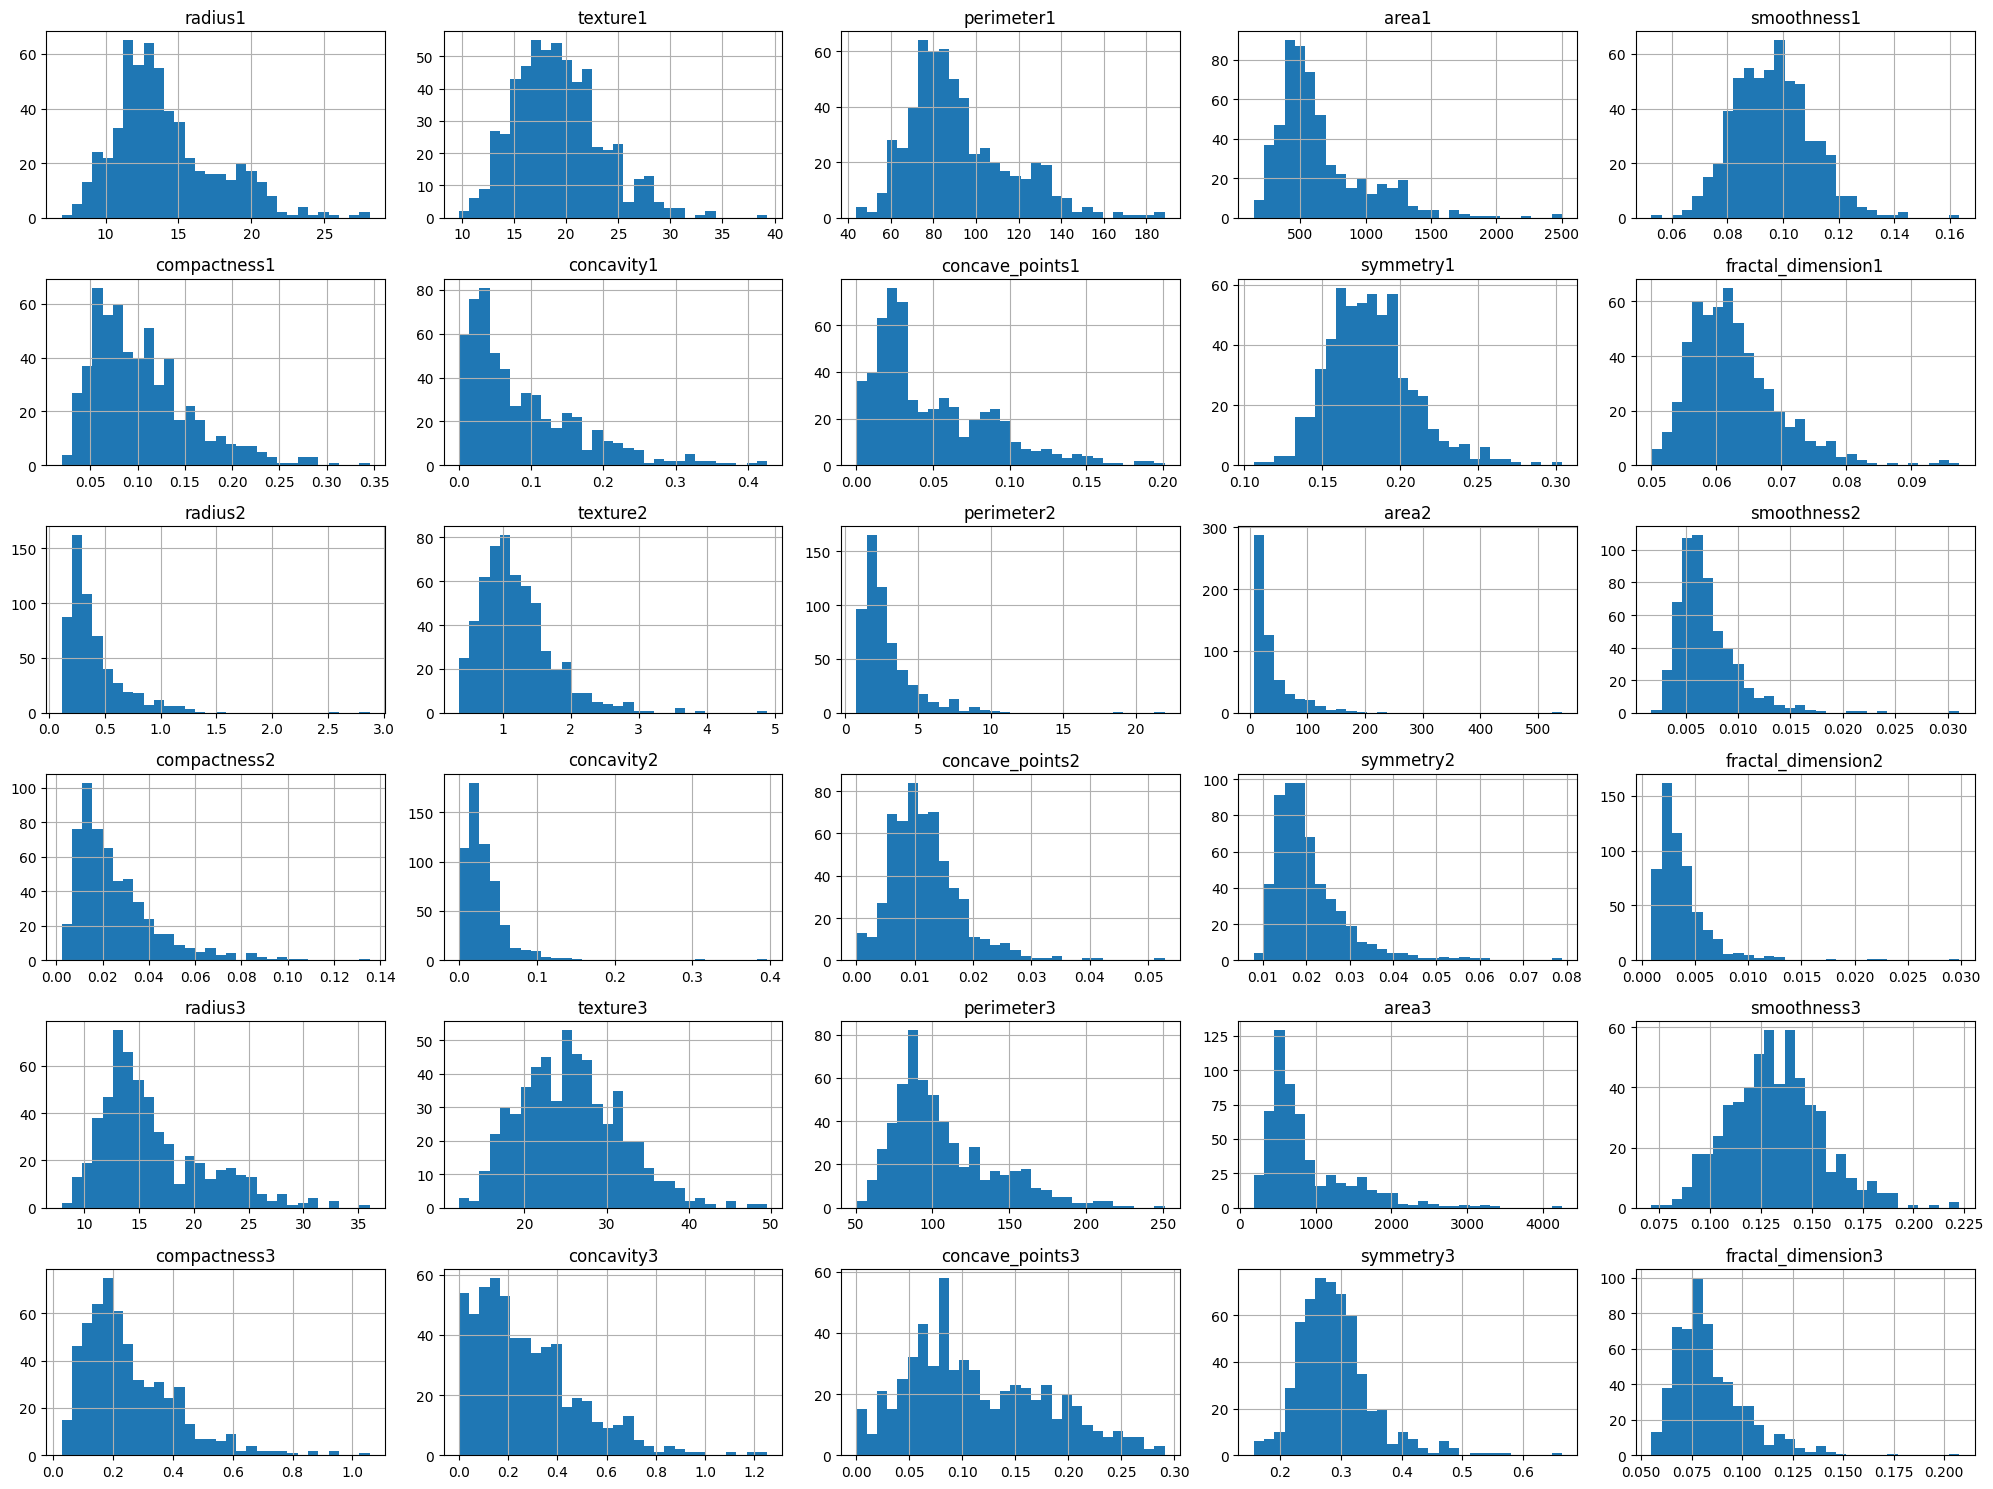

In [17]:
dataset.iloc[:, :-1].hist(bins=30, figsize=(20, 15), layout=(6, 5))
plt1.tight_layout()
plt1.show()


- No mapa de calor das correlações entre as características do dataset, pode-se observar que algumas características mostram correlações fortes entre si. Isso sugere a presença de redundância de informações, o que pode impactar a eficiência do modelo. Neste MVP não serão, contudo, aplicadas técnicas de redução de dimensionalidade, de forma que a análise mais aprofundada destas correlações poderá ser objeto de um incremento futuro do modelo.

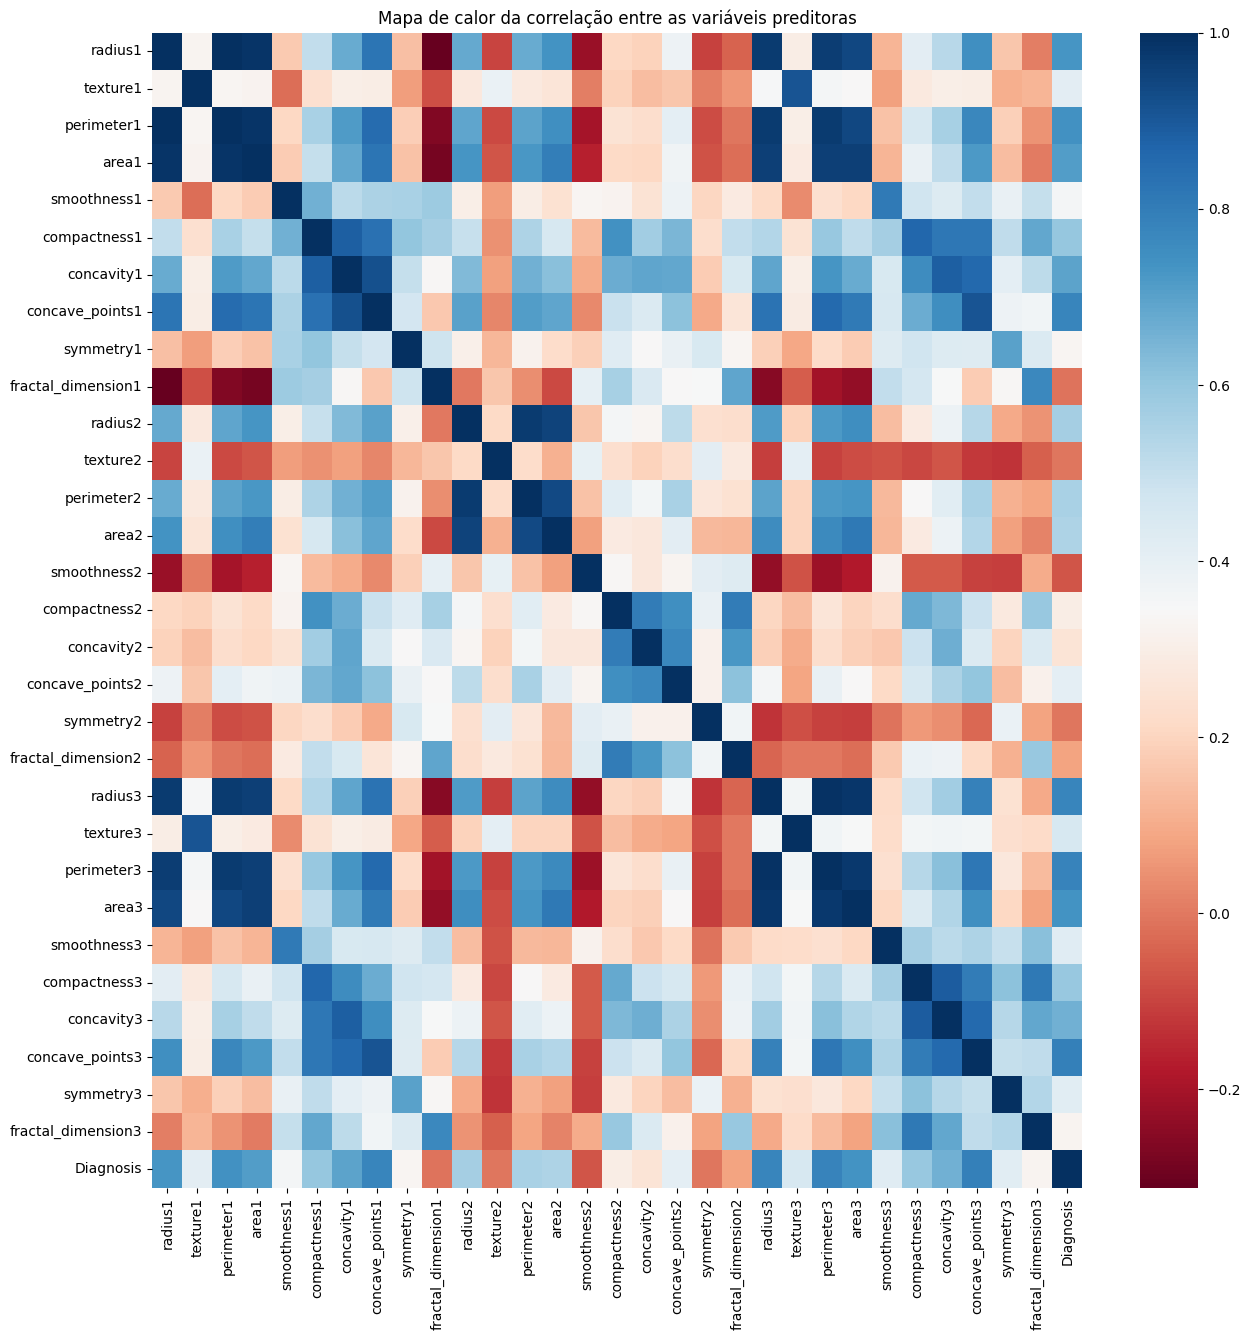

In [8]:
# Mapa de calor da correlação entre as variáveis
plt1.figure(figsize=(15,15))
sns.heatmap(dataset.corr(),
            annot=False,
            cmap='RdBu')
plt1.title('Mapa de calor da correlação entre as variáveis preditoras')
plt1.show()

#4. Pré-processamento

##4.1 Separação em conjuntos de treino e teste com _holdout_ estratificado

Utilizou o _holdout_ estratificado para a separação do dataset nos subconjuntos de treino e de teste. Para isto, utilizou-se a proporção de 20% dos dados para teste e 80% para treino, mantendo-se a proporção de tumores malignos (encontrada em todo o dataset) para ambos os conjuntos.

In [18]:
# Separação em conjuntos de treino e teste
X = features.values  # converte o objeto DataFrame (o dataset de features) do pandas em um array NumPy
y = numeric_target.values # converte o objeto DataFrame (o dataset de target) do pandas em um array NumPy

# Aplicação do holdout para divisão em 80% treino e 20% teste
test_size = 0.20 # tamanho do conjunto de teste
seed = 4 # semente aleatória

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # executa o holdout com estratificação

#5. Modelagem

##5.1. Preparação do _Pipeline_

Como pôde-se observar na etapa de análise dos dados, o _dataset_ possui dados com escalas muito diferentes entre as _features_. Desta forma, utilizaremos duas técnicas para redimensionar os dados: a padronização e a normalização. Para isso serão utilizadas, respectivamente,  duas classes do módulo _sklearn.preprocessing_: a _StandardScaler_ e a _MinMaxScaler_.
<br />
<br />
**StandardScaler**

StandardScaler padroniza os dados, ou seja, remove a média e escala os dados para que tenham uma variância unitária. Ele transforma os dados para que a média de cada _feature_ seja 0 e a variância seja 1.

$$\small z_i = \dfrac{x_i - \mu}{\sigma} $$

onde:

- $x_i$ é o valor original do $i$-ésimo valor da _feature_
- $\mu$ é a média dos valores da _feature_
- $\sigma$ é o desvio padrão dos valores da _feature_

<br />

**MinMaxScaler**

MinMaxScaler escala e transforma os dados para um intervalo específico, geralmente entre 0 e 1. Ele transforma os dados para que o menor valor de uma _feature_ seja 0 e o maior valor seja 1.

$$\small z_i = \dfrac{x_i-min(x)}{max(x)-min(x)}$$

onde:
- $x_i$ é o valor original do $i$-ésimo valor da _feature_
- $min(x)$ é o menor valor da _feature_
- $max(x)$ é o maior valor da _feature_

<br />

Foram montados _pipelines_ para os dados originais, padronizados e normalizados, utilizando, para cada um, os quatro algoritmos utilizados nos dados de treino, totalizando 12 modelos treinados. Os algoritmos utilizados foram:

- KNN (K-Nearest Neighbors): algoritmo não paramétrico, que não assume premissas sobre a distribuição dos dados. Sua ideia principal é considerar que os exemplos vizinhos são similares ao exemplo cuja informação se deseja inferir.
- Árvore de Classificação: algoritmo que segmenta os dados em subconjuntos, fazendo perguntas "sim/não" em cada nó, até que as amostras sejam divididas em grupos homogêneos com relação à classe alvo.
- Naive Bayes: é um classificador probabilístico baseado no Teorema de Bayes, que assume que todas as características são independentes entre si (por isso chamado de ingênuo), calculando a probabilidade de uma amostra pertencer a uma classe, com base em um conhecimento _a priori_.
- SVM (Support Vector Machine): O SVM é um dos algoritmos mais efetivos para classificação. ELe tenta encontrar uma linha ou hiperplano que melhor separe as classes no espaço de características, maximizando a margem entre os pontos mais próximos de cada classe.

In [20]:
# Parâmetros
np.random.seed(7) # definindo uma semente global para este bloco
scoring = 'accuracy'

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())  # padronização
min_max_scaler = ('MinMaxScaler', MinMaxScaler())  # normalização


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

##5.2. Criação e avaliação de modelos: dados originais, padronizados e normalizados

A fim de evitar tanto o _underfitting_ quanto o _overfitting_, foi utilizada a validação cruzada, _10-fold cross-validation_, para o treino dos modelos.

KNN-orig: 0.947 (0.033)
CART-orig: 0.932 (0.040)
NB-orig: 0.943 (0.049)
SVM-orig: 0.923 (0.046)
KNN-padr: 0.967 (0.024)
CART-padr: 0.934 (0.022)
NB-padr: 0.936 (0.047)
SVM-padr: 0.980 (0.023)
KNN-norm: 0.969 (0.030)
CART-norm: 0.923 (0.028)
NB-norm: 0.936 (0.047)
SVM-norm: 0.982 (0.031)


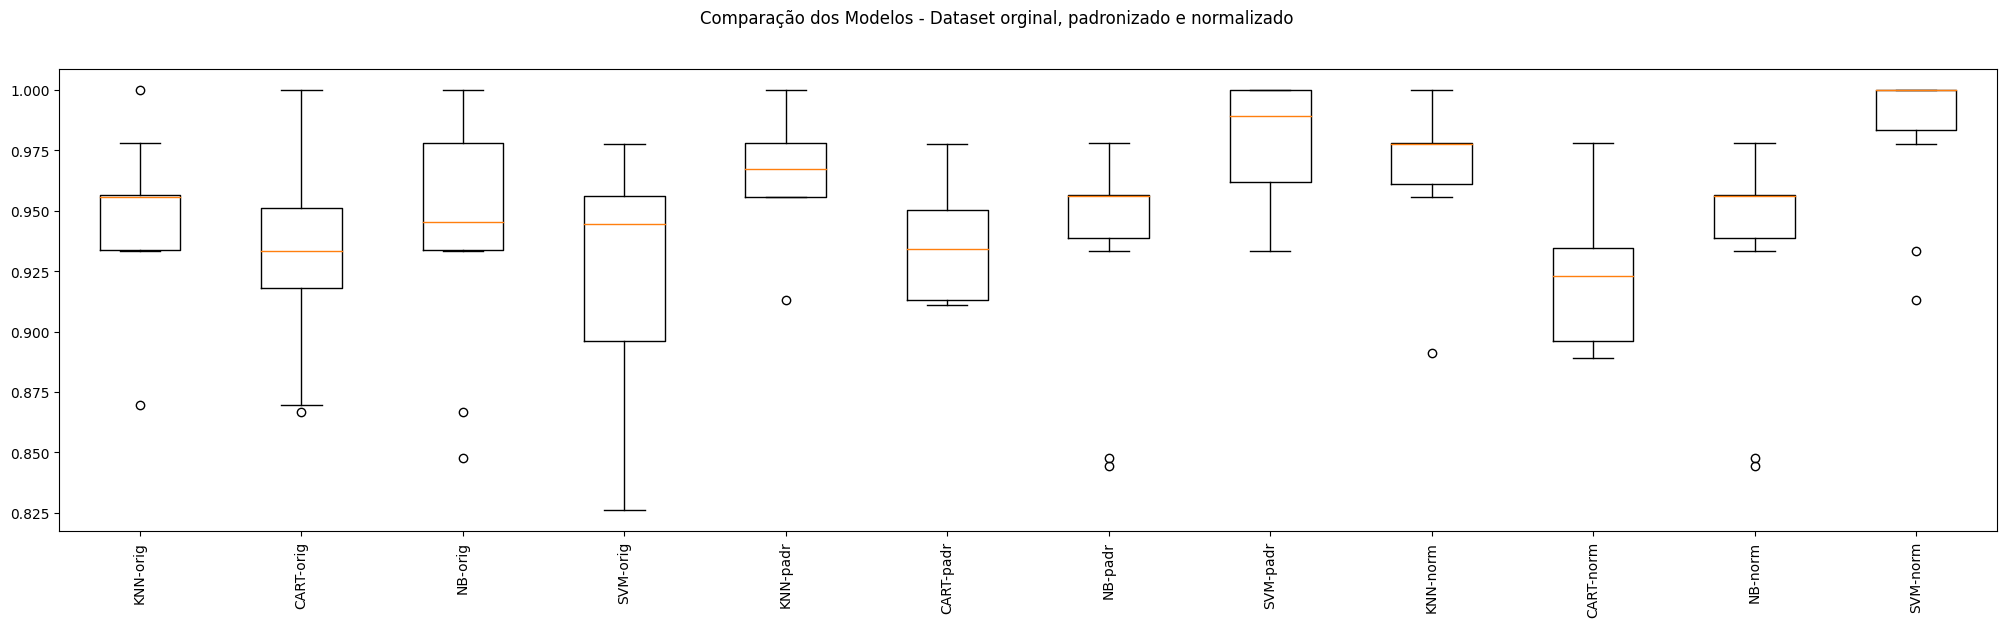

In [21]:
# Parâmetros e partições da validação cruzada
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt1.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt1.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt1.show()

##5.3. Otimização dos hiperparâmetros

O algoritmo que obteve o melhor desempenho foi o SVM, com uma acurácia média de 0.982 e desvio-padrão de 0.031. Desta forma, para otimizar ainda mais o modelo de classificação, foi feita a otimização dos hiperparâmetros do algoritmo SVM.

Para isto, utilizou-se um conjunto de 4 valores para o parâmetro C, que define a “rigidez” da margem e controla o _trade-off_ entre o tamanho desta e o erro do classificador, 4 valores para o parâmetro _gamma_, que define quão longe a influência de um único ponto de treinamento alcança, e 2 valores para o parâmetro_kernel_, que define o tipo de função kernel a ser usada. Os valores utilizados estão listados a seguir e totalizaram 320 combinações possíveis de modelos, considerando a validação cruzada _10-fold_.

> C: {0.1, 1, 10, 100};  
> _gamma_: {1, 0.1, 0.01, 0.001}; e  
> _kernel_: {RBF, Linear}  

O melhor resultado obtido foi o que utilizou os dados padronizados, com o seguinte conjunto de hiperparâmetros:

> C: 10;  
> _gamma_: 0.01; e  
> _kernel_: RBF

In [22]:
# Otimização do hiperparâmetros do Modelo escolhido (SVM)
np.random.seed(7) # definindo uma semente global para este bloco
pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('SVM-orig', Pipeline(steps=[svm])))
pipelines.append(('SVM-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('SVM-norm', Pipeline(steps=[min_max_scaler, svm])))

# Definindo os conjuntos de hiperparâmetros a serem testados:
param_grid = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__gamma': [1, 0.1, 0.01, 0.001],
    'SVM__kernel': ['rbf', 'linear']
}

# Preparando e executando o GridSearchCV e medindo a acurácia de cada modelo
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

SVM-orig - Melhor: 0.964879 usando {'SVM__C': 1, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
SVM-padr - Melhor: 0.991159 usando {'SVM__C': 10, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}
SVM-norm - Melhor: 0.986715 usando {'SVM__C': 10, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}


Uma vez escolhidos os melhores parâmetros e o melhor conjunto de dados (padronizados), o modelo foi treinado com os dados de treino.

In [24]:
# Preparação do modelo escolhido
scaler = StandardScaler().fit(X_train)
rescaledXTrain = scaler.transform(X_train)
model = SVC(C=10, gamma=0.01, kernel='rbf')
model.fit(rescaledXTrain, y_train)

SVC(C=10, gamma=0.01)

##5.4. Avaliação do Modelo

Para avaliar o desempenho do modelo escolhido, este foi aplicado ao conjunto de testes e foram calculadas as seguintes métricas: Acurácia, Precisão, Recall e F1-score.
<br />
<br />

Considerando os resultados obtidos na matriz de confusão apresentada abaixo e, ainda, que:
- $\small VP$ é o número de Verdadeiros Positivos, ou seja, casos originalmente positivos que o modelo classificou corretamente como positivos;
- $\small VN$ é o número de Verdadeiros Negativos, ou seja, casos originalmente negativos que o modelo classificou corretamente como negativos;
- $\small FP$ é o número de Falsos Positivos, ou seja, casos originalmente negativos que o modelo classificou erroneamente como positivos;
- $\small FN$ é o número de Falsos Negativos, ou seja, casos originalmente positivos que o modelo classificou erroneamente como negativos;

podemos definir as métricas utilizadas como:

<br />

**Acurácia**

A acurácia é a proporção de previsões corretas feitas pelo modelo, dada por:

<br />
$$\small Acurácia= \dfrac{VP+VN}{VP+VN+FP+FN}$$

<br />
<br />

**Precisão**

A precisão é a proporção de dados classificados como positivos que eram realmente positivos, dada por:

$$\small Precisão = \dfrac{VP}{VP+FP} $$
<br />
<br />

**Recall**

O Recall é a proporção de dados que eram realmente positivos e que foram classificados corretamente pelo modelo como positivos, dado por:

<br />
$$\small Recall= \dfrac{VP}{VP+FN}$$
<br />
<br />

**F1-score**

O F1-score é a média harmônica entre precisão e recall, o que permite uma avaliação da qualidade geral do modelo, dado por:

$$\small F1-score = \dfrac{2*Precisão*Recall}{Precisão + Recall}$$


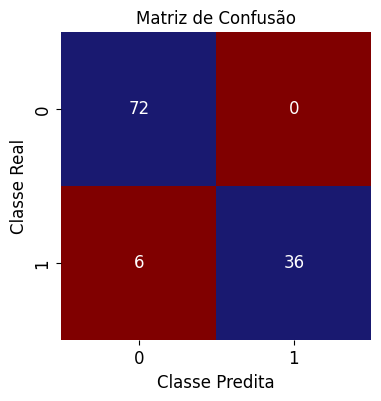

In [25]:
# Aplicação do modelo no conjunto de testes
rescaledXTest = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledXTest)

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, predictions)
plt1.figure(figsize=(4, 4))
my_colors = ['Maroon', 'MidnightBlue']
my_cmap = colors.ListedColormap(my_colors)
ax=sns.heatmap(conf_matrix, annot=True, cmap=my_cmap, annot_kws={"size": 12}, cbar=False)
ax.tick_params(axis='both', which='major', labelsize=12)
plt1.title('Matriz de Confusão', fontsize=12)
plt1.ylabel('Classe Real', fontsize=12)
plt1.xlabel('Classe Predita', fontsize=12)
plt1.show()

In [26]:
# Cálculo das Métricas de Avaliação de desempenho
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Acurácia: 0.9474
Precisão: 1.0000
Recall: 0.8571
F1-score: 0.9231


De acordo com os resultados obtidos, temos que:

- Acurácia: o modelo classificou corretamente 94,74% do dataset.
- Precisão: 100% dos casos classificados pelo modelo como malignos eram realmente malignos.
- _Recall_: o modelo conseguiu acertar 85,71% casos malignos.
- F1-_score_: o modelo apresenta um bom equilíbrio entre a Precisão e o Recall.

Desta forma, pode-se concluir que, apesar do modelo apresentar uma excelente acurácia e uma precisão perfeita, que indica que não houve falsos positivos, ele apresentou um percentual de falsos negativos de cerca de 15%, ou seja, casos em que os tumores eram malignos, mas que foram classidficados como benignos, o que poderia levar a consequências graves para os pacientes.

Por fim, o F1-score reflete um bom equilíbrio entre precisão e _recall_, mas sugere que há espaço para melhorar a detecção de casos malignos, possivelmente ajustando o modelo para reduzir falsos negativos, sem comprometer significativamente a precisão.

Este resultado está em linha com o leve desbalanceamento encontrado na análise exploratória dos dados, mas por se tratar de um MVP, este refinamento não será realizado, ficando  para um incremento futuro do modelo.

##5.5. Finalização do modelo

In [27]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y) # treinamento do modelo com TODO o dataset
predictions = model.predict(rescaledX)

#6. Exportação do Modelo

A exportação do modelo foi realizada utilizando-se a biblioteca _pickle_.

In [43]:
filename = 'modelo.pkl'
dump(model, open(filename, 'wb'))
!ls

modelo.pkl  sample_data


#7. Simulação do modelo com dados não vistos

Foram simulados 3 novas entradas de dados, ou seja, dados para os quais não se sabe o diagnóstico, a fim de que o modelo pudesse prever os resultados dos tumores. A predição do modelo apresentou os seguintes resultados:

- Tumor 1: Benigno
- Tumor 2: Maligno
- Tumor 3: Maligno


In [30]:
# Novos dados
data = {'radius1':  [14.5, 18.2, 16.1],
        'texture1': [20.4, 15.3, 19.2],
        'perimeter1': [95.0, 130.1, 115.3],
        'area1': [700, 900, 800],
        'smoothness1': [0.1, 0.2, 0.15],
        'compactness1': [0.15, 0.25, 0.2],
        'concavity1': [0.1, 0.35, 0.2],
        'concave_points1': [0.05, 0.12, 0.08],
        'symmetry1': [0.18, 0.25, 0.22],
        'fractal_dimension1': [0.06, 0.08, 0.07],
        'radius2': [0.3, 0.4, 0.35],
        'texture2': [1.1, 1.2, 1.0],
        'perimeter2': [2.5, 3.1, 2.8],
        'area2': [50, 60, 55],
        'smoothness2': [0.005, 0.007, 0.006],
        'compactness2': [0.02, 0.03, 0.025],
        'concavity2': [0.015, 0.04, 0.03],
        'concave_points2': [0.01, 0.02, 0.015],
        'symmetry2': [0.02, 0.03, 0.025],
        'fractal_dimension2': [0.001, 0.002, 0.0015],
        'radius3': [16.0, 20.2, 17.5],
        'texture3': [25.0, 28.2, 27.1],
        'perimeter3': [105.0, 150.2, 120.3],
        'area3': [850, 1100, 950],
        'smoothness3': [0.12, 0.3, 0.22],
        'compactness3': [0.2, 0.35, 0.25],
        'concavity3': [0.15, 0.4, 0.3],
        'concave_points3': [0.1, 0.2, 0.15],
        'symmetry3': [0.2, 0.35, 0.3],
        'fractal_dimension3': [0.07, 0.09, 0.08]
        }

# Colunas correspondentes ao dataset original
atributos = data.keys()
entrada = pd.DataFrame(data, columns=atributos)

# Conversão para valores numéricos
array_entrada = entrada.values
X_entrada = array_entrada.astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)

# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print("Previsões de classes:")
print(saidas)

Previsões de classes:
[0 1 1]


#8. Conclusão